In [6]:
import requests
import json
from datetime import datetime
import pandas as pd

In [7]:
# todo: swap this out (not necessary)
api_key = 'DzWZ29-TG!L6AgSmhbPG'
email = 'yu.melo@northeastern.edu'
# major democratic countries in europe
countries = 'Belgium|France|Germany|Italy|Spain|United%20States|United%20Kingdom|Australia'
countrycodes = 'BE;FR;DE;IT;ES;US;GB;AU'
fields = 'event_id_cnty|event_date|event_type|sub_event_type|country|latitude|longitude|location'
years = '2020|2021|2022'

# url with all countries, number of events per country, and event type
url = f'https://api.acleddata.com/acled/read.csv?key={api_key}&email={email}&country={countries}&event_type=Protests&limit=0&year={years}&fields=event_id_cnty|event_date|event_type|sub_event_type|country|latitude|longitude|location'

print(url)

https://api.acleddata.com/acled/read.csv?key=DzWZ29-TG!L6AgSmhbPG&email=yu.melo@northeastern.edu&country=Belgium|France|Germany|Italy|Spain|United%20States|United%20Kingdom|Australia&event_type=Protests&limit=0&year=2020|2021|2022&fields=event_id_cnty|event_date|event_type|sub_event_type|country|latitude|longitude|location


In [8]:
import requests
data = pd.read_csv(url)
data


,event_id_cnty,event_date,event_type,sub_event_type,country,latitude,longitude,location
0,DEU14296,2022-12-31,Protests,Peaceful protest,Germany,47.9946,7.8484,Freiburg im Breisgau
1,DEU14304,2022-12-31,Protests,Peaceful protest,Germany,52.5177,13.4024,Berlin - Mitte
2,DEU14306,2022-12-31,Protests,Peaceful protest,Germany,53.0751,8.8083,Bremen
3,DEU14331,2022-12-31,Protests,Peaceful protest,Germany,48.1374,11.5755,Munchen
4,ESP12099,2022-12-31,Protests,Peaceful protest,Spain,39.5722,2.6473,Palma de Mallorca
...,...,...,...,...,...,...,...,...
118288,GBR3,2020-01-01,Protests,Peaceful protest,United Kingdom,51.4417,-2.6244,Ashton Gate
118289,GBR4,2020-01-01,Protests,Peaceful protest,United Kingdom,50.2091,-5.4904,St Ives
118290,ITA4,2020-01-01,Protests,Peaceful protest,Italy,45.5463,11.5503,Vicenza
118291,ITA1,2020-01-01,Protests,Peaceful protest,Italy,45.1373,7.1487,Bussoleno


In [9]:
# turns the event_date column into a datetime object
data['event_date'] = pd.to_datetime(data['event_date'])
print(data['event_date'].dtype)

# makes a dataframe with the number of events per country per year
grouped_data = data.groupby([data['event_date'].dt.year, 'country']).size().reset_index(name='counts')

# turns the year column into a string
grouped_data['event_date'] = grouped_data['event_date'].astype(str)
print(grouped_data['event_date'].dtype)
grouped_data

datetime64[ns]
object


,event_date,country,counts
0,2020,Belgium,784
1,2020,France,5165
2,2020,Germany,4292
3,2020,Italy,5488
4,2020,Spain,3348
5,2020,United Kingdom,2196
6,2020,United States,21585
7,2021,Australia,681
8,2021,Belgium,833
9,2021,France,8356


In [10]:
# makes a call to the World Bank API to get the population of each country
pop_url = f'http://api.worldbank.org/v2/country/{countrycodes}/indicator/SP.POP.TOTL?date=2020:2022&format=json'
pop_data = requests.get(pop_url).json()
pop_data

# creates a pandas dataframe with the country, year, and population data
pop_df = pd.DataFrame(pop_data[1])
# cleans up the dataframe
pop_df = pop_df.drop(columns=['indicator', 'countryiso3code', 'unit', 'obs_status', 'decimal'])

# gets just the value of the country dict
pop_df['country'] = pop_df['country'].apply(lambda x: x['value'])

# renames date column to event_date, turns the event_date column into a string
pop_df = pop_df.rename(columns={'date': 'event_date'})
pop_df['event_date'] = pop_df['event_date'].astype(str)
print(pop_df['event_date'].dtype)
pop_df

# renames the value column to population
pop_df = pop_df.rename(columns={'value': 'population'})
pop_df


object


,country,event_date,population
0,Australia,2022,26005540
1,Australia,2021,25685412
2,Australia,2020,25649248
3,Belgium,2022,11685814
4,Belgium,2021,11586195
5,Belgium,2020,11538604
6,Germany,2022,83797985
7,Germany,2021,83196078
8,Germany,2020,83160871
9,Spain,2022,47778340


In [11]:
# combines the population data with the event data into one dataframe on country and year. There should be one entry for each country per year.
combined_data = pd.merge(grouped_data, pop_df, on=['country', 'event_date'])

# sort the data by country first, then year
combined_data = combined_data.sort_values(by=['country', 'event_date'])
combined_data

,event_date,country,counts,population
7,2021,Australia,681,25685412
15,2022,Australia,794,26005540
0,2020,Belgium,784,11538604
8,2021,Belgium,833,11586195
16,2022,Belgium,523,11685814
1,2020,France,5165,67571107
9,2021,France,8356,67764304
17,2022,France,6421,67971311
2,2020,Germany,4292,83160871
10,2021,Germany,4215,83196078


In [12]:
# creates a new column with the number of events per 100,000 people
combined_data['events_per_capita'] = combined_data['counts'] / combined_data['population'] * 100000
combined_data

,event_date,country,counts,population,events_per_capita
7,2021,Australia,681,25685412,2.651310
15,2022,Australia,794,26005540,3.053196
0,2020,Belgium,784,11538604,6.794583
8,2021,Belgium,833,11586195,7.189591
16,2022,Belgium,523,11685814,4.475512
1,2020,France,5165,67571107,7.643800
9,2021,France,8356,67764304,12.330976
17,2022,France,6421,67971311,9.446633
2,2020,Germany,4292,83160871,5.161081
10,2021,Germany,4215,83196078,5.066345


In [13]:
# fetches gdp per capita data from the World Bank API
gdp_url = f'http://api.worldbank.org/v2/country/{countrycodes}/indicator/NY.GDP.PCAP.CD?date=2020:2022&format=json'
gdp_data = requests.get(gdp_url).json()
gdp_data

# cleans up the data and creates a dataframe
gdp_df = pd.DataFrame(gdp_data[1])
gdp_df = gdp_df.drop(columns=['indicator', 'countryiso3code', 'unit', 'obs_status', 'decimal'])
gdp_df['country'] = gdp_df['country'].apply(lambda x: x['value'])
gdp_df = gdp_df.rename(columns={'date': 'event_date'})
gdp_df['event_date'] = gdp_df['event_date'].astype(str)

# names the value column to gdp_per_capita
gdp_df = gdp_df.rename(columns={'value': 'gdp_per_capita'})

gdp_df

,country,event_date,gdp_per_capita
0,Australia,2022,65099.845912
1,Australia,2021,60697.245436
2,Australia,2020,51868.247557
3,Belgium,2022,49926.825430
4,Belgium,2021,51850.397184
5,Belgium,2020,45609.003494
6,Germany,2022,48717.991140
7,Germany,2021,51426.750365
8,Germany,2020,46749.476228
9,Spain,2022,29674.544286


In [14]:
# merges the gdp data with the combined data
combined_data = pd.merge(combined_data, gdp_df, on=['country', 'event_date'])
combined_data
combined_data.to_csv('combined_present.csv', index=False)


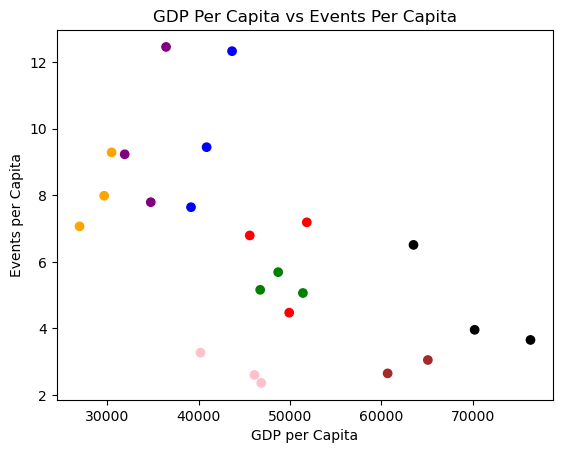

In [15]:
# creates a scatter plot of the number of events per capita and the gdp per capita
# each point should represent a country in a given year, and different countries should be different colors
import matplotlib.pyplot as plt

colors = {
    'Belgium': 'red',
    'France': 'blue',
    'Germany': 'green',
    'Italy': 'purple',
    'Spain': 'orange',
    'United States': 'black',
    'United Kingdom': 'pink',
    'Australia': 'brown'
}
plt.scatter(combined_data['gdp_per_capita'], combined_data['events_per_capita'], c=combined_data['country'].apply(lambda x: colors[x]))
plt.xlabel('GDP per Capita')
plt.ylabel('Events per Capita')
plt.title('GDP Per Capita vs Events Per Capita')
plt.show()
